In [1]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python                                                                         

Mounted at /content/drive
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [2]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

     |████████████████████████████████| 409kB 11.0MB/s 


In [3]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
from sklearn.metrics import mean_absolute_error,mean_squared_error
from utils import date_transform,evaluation_function,plot_metrics,plot_real_vs_pred,train_test_val_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_columns=None
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
sns.set_palette("Set2")
sns.set_style("ticks")

Ing_AEMET=Ingestion_AEMET()



#2- Reading DataFrames from pickle

In [4]:
df_ree_weather=pd.read_pickle(Ing_AEMET.path_Data+"Wheater_ree.pkl")

In [5]:
df_ree_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7480 entries, 0 to 7479
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      7480 non-null   object 
 1   system                     7480 non-null   object 
 2   Holiday                    7480 non-null   int64  
 3   weekday                    7480 non-null   int64  
 4   tmin                       7480 non-null   float64
 5   presMin                    7480 non-null   float64
 6   prec                       7480 non-null   float64
 7   tmed                       7480 non-null   float64
 8   sol                        7480 non-null   float64
 9   velmedia                   7480 non-null   float64
 10  tmax                       7480 non-null   float64
 11  presMax                    7480 non-null   float64
 12  racha                      7480 non-null   float64
 13  year                       7480 non-null   int64

#3- Featuring

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc_system=OneHotEncoder().fit(df_ree_weather[['system']])

df_transform_weather=enc_system.transform(df_ree_weather[['system']])

column_weather=enc_system.get_feature_names()

df_onehot_weather = pd.DataFrame(df_transform_weather.todense(),columns=column_weather)

     
df_weather_features=pd.merge(df_ree_weather,df_onehot_weather,left_index=True,right_index=True)                               
df_weather_features.drop('system',axis=1,inplace=True)
                               

In [7]:
df_weather_features.head()

,fecha,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha,year,month,day,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x1_No-Renovable,x1_Renovable,x0_baleares,x0_canarias,x0_melilla,x0_peninsular
0,2016-01-01,1,4,3.300000,1009.300000,0.022222,13.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,2016,1,1,8814.678,3032.187,2277.467,69.160,11.053,0.0,0.000,0.000,1022.316,0.00,1.362,485.0490,485.0490,144.200,0.000,1286.835,0.000,0.000,0.927205,0.072795,1.0,0.0,0.0,0.0
1,2016-01-01,1,4,7.900000,894.700000,0.000000,18.040000,9.266667,2.781667,24.250000,1025.450000,10.400000,2016,1,1,20220.015,0.000,7124.185,0.000,383.526,0.0,11.815,9.163,6026.826,0.00,26.995,0.0000,0.0000,697.304,0.000,160.570,5779.631,0.000,0.944174,0.055826,0.0,1.0,0.0,0.0
2,2016-01-01,1,4,10.600000,1016.600000,0.000000,15.500000,9.100000,1.700000,20.400000,1019.900000,5.600000,2016,1,1,479.011,0.000,0.000,0.000,0.000,0.0,0.000,0.000,447.061,0.00,0.000,15.9025,15.9025,0.145,0.000,0.000,0.000,0.000,0.966499,0.033501,0.0,0.0,1.0,0.0
3,2016-01-01,1,4,3.817021,921.165957,5.477102,10.207533,2.231907,3.189763,16.440426,984.380851,16.361702,2016,1,1,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.000,29281.000,0.000,162745.22,7169.124,3848.0700,1179.2320,8179.808,695.552,0.000,0.000,9782.273,0.542084,0.457916,0.0,0.0,0.0,1.0
4,2016-01-02,0,5,3.900000,1006.400000,0.000000,13.588889,3.140000,4.488889,20.700000,1021.200000,23.300000,2016,1,2,9435.611,3269.033,2433.496,90.243,26.863,0.0,0.000,0.000,1189.254,0.00,2.335,458.4040,458.4040,194.499,0.000,1313.080,0.000,0.000,0.927710,0.072290,1.0,0.0,0.0,0.0


##  Tratamiento de fechas

Para pasar las fechas aun formato en que el salto entre el ultimo dia de un mes y el primer dia del siguiente sea continuo, uso los cosenos de los dias y meses. 

Para ello situo los valores de los 31 dias en angulos iguales calulandolos como $Dia(x)=\cos\frac{2\pi}{31}x$

Para los meses situo cada mes en $Mes(x)=\cos\frac{2\pi}{12}x$

Y para los dias de la semana $Weekday(x)=\cos\frac{2\pi}{7}x$

In [8]:
df_weather_procesed=date_transform(df_weather_features);
df_weather_procesed.head()

,fecha,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha,year,month,day,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x1_No-Renovable,x1_Renovable,x0_baleares,x0_canarias,x0_melilla,x0_peninsular
0,2016-01-01,1,-0.900969,3.300000,1009.300000,0.022222,13.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,7.608871,0.866025,0.979530,8814.678,3032.187,2277.467,69.160,11.053,0.0,0.000,0.000,1022.316,0.00,1.362,485.0490,485.0490,144.200,0.000,1286.835,0.000,0.000,0.927205,0.072795,1.0,0.0,0.0,0.0
1,2016-01-01,1,-0.900969,7.900000,894.700000,0.000000,18.040000,9.266667,2.781667,24.250000,1025.450000,10.400000,7.608871,0.866025,0.979530,20220.015,0.000,7124.185,0.000,383.526,0.0,11.815,9.163,6026.826,0.00,26.995,0.0000,0.0000,697.304,0.000,160.570,5779.631,0.000,0.944174,0.055826,0.0,1.0,0.0,0.0
2,2016-01-01,1,-0.900969,10.600000,1016.600000,0.000000,15.500000,9.100000,1.700000,20.400000,1019.900000,5.600000,7.608871,0.866025,0.979530,479.011,0.000,0.000,0.000,0.000,0.0,0.000,0.000,447.061,0.00,0.000,15.9025,15.9025,0.145,0.000,0.000,0.000,0.000,0.966499,0.033501,0.0,0.0,1.0,0.0
3,2016-01-01,1,-0.900969,3.817021,921.165957,5.477102,10.207533,2.231907,3.189763,16.440426,984.380851,16.361702,7.608871,0.866025,0.979530,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.000,29281.000,0.000,162745.22,7169.124,3848.0700,1179.2320,8179.808,695.552,0.000,0.000,9782.273,0.542084,0.457916,0.0,0.0,0.0,1.0
4,2016-01-02,0,-0.222521,3.900000,1006.400000,0.000000,13.588889,3.140000,4.488889,20.700000,1021.200000,23.300000,7.608871,0.866025,0.918958,9435.611,3269.033,2433.496,90.243,26.863,0.0,0.000,0.000,1189.254,0.00,2.335,458.4040,458.4040,194.499,0.000,1313.080,0.000,0.000,0.927710,0.072290,1.0,0.0,0.0,0.0


# Models for Total Generation

In [9]:
features_list=['Holiday','weekday','tmin','presMin','prec','sol','tmax','presMax','racha','velmedia','year','day','month','x0_baleares','x0_canarias','x0_melilla','x0_peninsular']
target_list=['Generacion_Mwh','x0_baleares','x0_canarias','x0_melilla','x0_peninsular']

##Train-Test split

In [10]:
X_train,X_test,y_train,y_test,X_validation,y_validacion=train_test_val_split(df_weather_procesed,
                                                                        features_list,
                                                                        target_list,
                                                                        .1,
                                                                        0)

In [11]:
X_train.shape

(6732, 17)

In [12]:
X_test.shape

(748, 17)

##Scaler

In [13]:
from sklearn.preprocessing import StandardScaler

cols_scaler=['tmin','presMin','prec','sol','tmax','presMax','racha','velmedia']
scaler=StandardScaler().fit(X_train[cols_scaler])

X_train[cols_scaler]=scaler.transform(X_train[cols_scaler])
X_test[cols_scaler]=scaler.transform(X_test[cols_scaler])
X_train.head()

,Holiday,weekday,tmin,presMin,prec,sol,tmax,presMax,racha,velmedia,year,day,month,x0_baleares,x0_canarias,x0_melilla,x0_peninsular
0,1,-0.900969,-1.136261,1.001632,-0.299348,-1.860133,-0.912298,0.989529,0.086529,-0.813986,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0
1,1,-0.900969,-0.427684,-1.208123,-0.305329,0.460875,-0.026751,1.022056,-0.660018,-0.508034,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0
2,1,-0.900969,-0.011780,1.142394,-0.305329,0.408077,-0.664014,0.693821,-1.603026,-1.305476,7.608871,0.979530,0.866025,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.056619,-0.697798,1.168923,-1.767660,-1.319413,-1.406834,0.511217,-0.207171,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.043838,0.945714,-0.305329,-1.479986,-0.614357,0.770705,1.874314,0.750589,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0


##Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression


reg_ln=LinearRegression()

reg_ln.fit(X_train,y_train['Generacion_Mwh'])

y_pred_ln=reg_ln.predict(X_test)


##K-Neighbors

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

param_KN={"n_neighbors":np.arange(3,100)}

reg_KN=GridSearchCV(KNeighborsRegressor(),param_grid=param_KN,scoring='neg_mean_squared_error')
reg_KN.fit(X_train,y_train['Generacion_Mwh'])
y_pred_KN=reg_KN.predict(X_test)
reg_KN.best_params_

{'n_neighbors': 16}

## Decision Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor

params_DT={'max_depth':range(3,10),'min_samples_leaf':range(1,5)}

reg_DT=GridSearchCV(DecisionTreeRegressor(random_state=7),param_grid=params_DT,scoring='neg_mean_squared_error')
reg_DT.fit(X_train,y_train['Generacion_Mwh'])
y_pred_DT=reg_DT.predict(X_test)
reg_DT.best_params_

{'max_depth': 5, 'min_samples_leaf': 4}

#K-Neighbors Bagging Model

In [18]:
from sklearn.ensemble import BaggingRegressor

params_BKN={
    "base_estimator__n_neighbors":np.arange(3,20),
    "n_estimators":np.arange(3,20),
    "max_features":np.arange(.5,1,.1)
}

reg_BKN=GridSearchCV(BaggingRegressor(KNeighborsRegressor()),param_grid=params_BKN,scoring='neg_mean_squared_error')

reg_BKN.fit(X_train,y_train['Generacion_Mwh'])
y_pred_BKN=reg_BKN.predict(X_test)
reg_BKN.best_params_

{'base_estimator__n_neighbors': 7, 'max_features': 0.5, 'n_estimators': 14}

##Boosting Models


###XGBoost

In [ ]:
from xgboost import XGBRegressor

params_xgb={
    'max_depth':range(3,6),
    'n_estimators':range(60,80,1),
    'learning_rate':np.arange(.11,.13,.005),
    'subsample':np.arange(.4,0.6,0.05),
    'colsample_bytree':np.arange(.5,1,0.1)
    }

reg_XGB=GridSearchCV(XGBRegressor(objective='reg:squarederror',random_state=7),param_grid=params_xgb,scoring='neg_mean_squared_error')

reg_XGB.fit(X_train,y_train['Generacion_Mwh'])
y_pred_XGB=reg_XGB.predict(X_test)

print(reg_XGB.best_params_)
print(reg_XGB.best_estimator_)
print(reg_XGB.best_score_)

{'colsample_bytree': 0.7, 'learning_rate': 0.115, 'max_depth': 5, 'n_estimators': 79, 'subsample': 0.4}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.115, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=79,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.4, verbosity=1)
-939064460.3294872


###LightGBM

In [ ]:
from lightgbm import LGBMRegressor

params_LGBM={
    'max_depth':range(3,6),
    'n_estimators':range(110,130,1),
    'learning_rate':np.arange(.09,.11,.005),
    'subsample':np.arange(.3,0.6,0.05),
    'colsample_bytree':np.arange(.5,1,0.1)
    }

reg_LGBM=GridSearchCV(LGBMRegressor(random_state=7),param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(X_train,y_train['Generacion_Mwh'])
y_pred_LGBM=reg_LGBM.predict(X_test)

print(reg_LGBM.best_params_)
print(reg_LGBM.best_estimator_)
print(reg_LGBM.best_score_)

{'colsample_bytree': 0.6, 'learning_rate': 0.095, 'max_depth': 5, 'n_estimators': 111, 'subsample': 0.3}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
              importance_type='split', learning_rate=0.095, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=111, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.3, subsample_for_bin=200000, subsample_freq=0)
-823778544.6687001


# Evaluation for Total Generation


## Model choice

,Model_name,MAE,RMSE
0,LinearRegresion (Base Model),19339.859361,41208.403990
0,BKNeighbors,35200.296965,57557.256468
0,DecissionTree,14255.386970,39735.633245
0,XGBoost,12980.098423,34594.049160
0,LightGBM,11966.253682,34803.811942


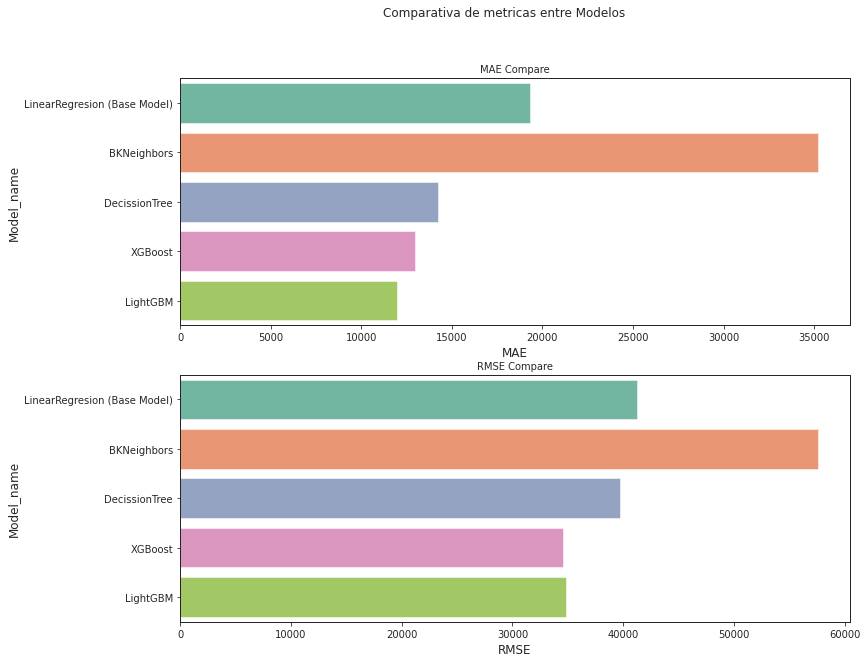

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

pd_ln=evaluation_function(y_test['Generacion_Mwh'],y_pred_ln,'LinearRegresion (Base Model)')
pd_kn=evaluation_function(y_test['Generacion_Mwh'],y_pred_KN,'KNeighbors')
pd_bkn=evaluation_function(y_test['Generacion_Mwh'],y_pred_BKN,'Bagging KNeighbors')
pd_DT=evaluation_function(y_test['Generacion_Mwh'],y_pred_DT,'DecissionTree')
pd_XGB=evaluation_function(y_test['Generacion_Mwh'],y_pred_XGB,'XGBoost')
pd_LGBM=evaluation_function(y_test['Generacion_Mwh'],y_pred_LGBM,'LightGBM')

plot_metrics([pd_ln,pd_kn,pd_bkn,pd_DT,pd_XGB,pd_LGBM])

pd_metrics

## Real vs prediction comparation

In [ ]:
plot_real_vs_pred('x0_peninsular','Generacion_Mwh',X_test,y_test,reg_ln,reg_KN,reg_DT,reg_XGB,reg_LGBM)

NameError: ignored

In [ ]:
plot_real_vs_pred('x0_canarias','Generacion_Mwh',X_test,y_test,reg_ln,reg_KN,reg_DT,reg_XGB,reg_LGBM)

# Pipeline

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

cols=['day','year','month','system','Holiday','weekday','tmin','tmed','presMin','prec','sol','velmedia','tmax','presMax','racha']

ct=ColumnTransformer(
    [
     ('enc',enc_system,['system']),
     ('date_transf',FunctionTransformer(date_transform),['day','year','month','weekday']),
     ('sc',StandardScaler(),['tmin','presMin','prec','sol','tmax','tmed','presMax','racha','velmedia'])
    ]
)

pipe_best_total=Pipeline(steps=[('ct',ct),('LGBM',LGBMRegressor(random_state=7))])

params_LGBM={
    'LGBM__max_depth':[5],
    'LGBM__n_estimators':[112],
    'LGBM__learning_rate':[.11],
    'LGBM__subsample':[.4]
    }

reg_LGBM=GridSearchCV(pipe_best_total,param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(df_ree_weather[cols],df_ree_weather['Generacion_Mwh'])

joblib.dump(reg_LGBM, 'best_model_Generation.sav')

['best_model_Generation.sav']